In [1]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

gym.logger.set_level(40)

# Custom packages
from agent.agent import Agent
from memories.ope_replay_buffer import OPETrajectoryData
from memories.collect_data import collect_data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Help functions

In [3]:
def reward_fn(reward, done):
    if done:
        return -1
    else:
        return 1

def one_episode_eval(env, agent, epsilon, reward_fn, trajectory_length=200, gamma=0.99):
    total_reward = 0
    discount = 1
    state = env.reset()
    for _ in range(trajectory_length):
        action = agent.act_e_greedy(state, epsilon=epsilon)
        next_state, reward, done, _ = env.step(action)
        if reward_fn is not None:
            reward = reward_fn(reward, done)
        elif done:
            raise ValueError(
            'Environment terminated but reward_fn is not specified.')
        total_reward += reward * discount
        state = next_state
        discount *= gamma
    return total_reward

def true_estimation(env, agent, epsilon, reward_fn, trajectory_length=200, gamma=0.99, n_episodes=100):
    return np.array([one_episode_eval(env, 
                                      agent, 
                                      epsilon, 
                                      reward_fn, 
                                      trajectory_length, 
                                      gamma) for i in range(n_episodes)]).mean()

## Get baseline policy

In [4]:
env = gym.make("CartPole-v0")
load_path = 'baseline_policy/weights'

baseline_agent = Agent(env)
baseline_agent.load_network(load_path)
baseline_agent.epsilon = 0.5

In [5]:
test_baseline = true_estimation(env, baseline_agent, baseline_agent.epsilon, reward_fn, n_episodes=500)
test_baseline

19.410846764471508

## Run DQN agent

In [6]:
def run_one_seed(conservative=False,
                 ope_technique='TRUE',
                 baseline_agent = None,
                 baseline_eps = None,
                 alpha=0.2,
                 total_episodes=200, 
                 fill_ope_buffer=200):
    """
    Possibilities for ope_techniques:
        - TRUE: simply an average over 100 episodes
        - DICE: 
        - IS
        - Weighted IS
    """
    
    # Logs and create lists for condition conservative
    episode_rewards, losses = [], []
    policy_hist, baseline_hist = [], []

    # Import buffers
    dqn_buffer = deque(maxlen=5000) # DQNReplayMemory(capacity=5000)
    ope_buffer = OPETrajectoryData()

    # Create env and agent
    env = gym.make("CartPole-v0")
    agent = Agent(env)

    # If conservative, fill ope buffers for initialization
    if conservative:
        dqn_buffer, ope_buffer, avg_episode_rewards, avg_step_rewards = \
            collect_data(env, baseline_agent, baseline_eps,
                         dqn_buffer, ope_buffer,
                         num_trajectories=200, trajectory_length=200, 
                         gamma=0.99, reward_fn=reward_fn, init=True)
        q_b = avg_episode_rewards
        
        print()
        print('Q_b:', q_b)

    # Training
    for episode in range(total_episodes):
    
        # Check if it works
        # if episode % 25 == 0 and episode > 1:
        #     print('episode:', episode)
        #     print('epsilon:', eps)
        #     print('rewards:', np.mean(episode_rewards[-4:]))
        #     print()

        # Get eps
        eps = 0.98**(2*episode)

        """
        Conservative agent or not
        """
        if conservative:
            baseline_hist.append(q_b)
            if ope_technique == 'TRUE':
                q_policy = true_estimation(env,
                                           agent, 
                                           eps,
                                           reward_fn)
                                
            else:
                raise ValueError('Not implemented yet.')

            LHS = np.sum(policy_hist) + q_policy
            RHS = (1-alpha) * np.sum(baseline_hist)
                
            condition = LHS - RHS > 0
            if episode % 5 == 0 and episode > 1:
                print()
                print('episode:', episode)
                print('q_b:', q_b)
                print('estimated q_policy:', q_policy)
                print('LHS:', LHS)
                print('RHS:', RHS)
                print('condition:', condition)
            
            # condition = True

            if condition:
                policy_hist.append(q_policy)
                play_policy = agent
            else:
                play_policy = baseline_agent
                eps = baseline_eps
                policy_hist.append(q_b)

        else:
            play_policy = agent
        
        # Collect one episode and put it inside buffers
        dqn_buffer, ope_buffer, avg_episode_rewards, avg_step_rewards = \
            collect_data(env, play_policy, eps,
                         dqn_buffer, ope_buffer,
                         num_trajectories=1, trajectory_length=200, 
                         gamma=0.99, reward_fn=reward_fn, init=False)

        # Train 200 times for DQN
        losses_episode = []
        for _ in range(30):
            loss = agent.train_iter(dqn_buffer)
            losses_episode.append(loss)

        # Update target network
        agent.update_target_net()

        # Logs
        episode_rewards.append(avg_episode_rewards)
        losses.append(np.mean(losses_episode))
        
    if conservative:
        return agent, episode_rewards, losses, q_b

    return agent, episode_rewards, losses

## Experiments

In [7]:
agent_normal, episode_rewards_normal, _ = run_one_seed()
agent_cons_true, episode_rewards_cons_true, _, q_b = \
    run_one_seed(conservative=True,
                 ope_technique='TRUE',
                 baseline_agent = baseline_agent,
                 baseline_eps = 0.5,
                 alpha=0.2,
                 total_episodes=200, 
                 fill_ope_buffer=200)


Q_b: 21.121782307390813

episode: 5
q_b: 21.121782307390813
estimated q_policy: -62.55687523412664
LHS: 43.052036302827425
RHS: 101.38455507547592
condition: False

episode: 10
q_b: 21.121782307390813
estimated q_policy: -61.83236354036223
LHS: 149.3854595335459
RHS: 185.87168430503917
condition: False

episode: 15
q_b: 21.121782307390813
estimated q_policy: -62.56710677588155
LHS: 254.25962783498062
RHS: 270.3588135346024
condition: False

episode: 20
q_b: 21.121782307390813
estimated q_policy: -62.1758577629162
LHS: 276.73386614967615
RHS: 354.84594276416556
condition: False

episode: 25
q_b: 21.121782307390813
estimated q_policy: -57.4439470361162
LHS: 387.0746884134303
RHS: 439.33307199372894
condition: False

episode: 30
q_b: 21.121782307390813
estimated q_policy: -55.131896808795055
LHS: 494.9956501777055
RHS: 523.8202012232923
condition: False

episode: 35
q_b: 21.121782307390813
estimated q_policy: -48.153290252906935
LHS: 607.5831682705478
RHS: 608.3073304528556
condition: Fa

## Plots

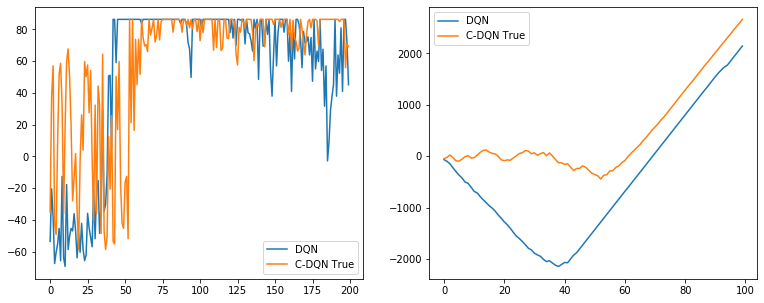

In [15]:
alpha = 0.2

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(episode_rewards_normal, label='DQN')
plt.plot(episode_rewards_cons_true, label='C-DQN True')
plt.legend()

plt.subplot(132)
plt.plot((np.cumsum(episode_rewards_normal) - ((1-alpha)*14.8366*np.ones(200)).cumsum())[:100], label='DQN')
plt.plot((np.cumsum(episode_rewards_cons_true) - ((1-alpha)*14.8366*np.ones(200)).cumsum())[:100], label='C-DQN True')
plt.legend()

plt.show()

## DICE

In [6]:
import warnings
warnings.filterwarnings('ignore')

from ope_techniques.dual_dice.dice_estimate_from_dataset import dice_estimation

In [7]:
agent_normal = Agent(env)
agent_normal.load_network(load_path)
agent_normal.epsilon = 0.001

In [8]:
baseline_agent.epsilon, agent_normal.epsilon

(0.5, 0.001)

In [9]:
true_estimation(env, agent_normal, agent_normal.epsilon, reward_fn, trajectory_length=200, gamma=0.99, n_episodes=200)


56.731329080431294

In [10]:
true_estimation(env, baseline_agent, baseline_agent.epsilon, reward_fn, trajectory_length=200, gamma=0.99, n_episodes=200)


16.621526314500674

In [11]:
gamma=0.99
env = gym.make("CartPole-v0")

# For learning
ope_buffer = OPETrajectoryData()
_, ope_buffer, baseline_avg_episode_rewards, baseline_avg_step_rewards = \
            collect_data(env, baseline_agent, baseline_agent.epsilon,
                         None, ope_buffer,
                         num_trajectories=800, trajectory_length=200, 
                         gamma=0.99, reward_fn=reward_fn, init=True)

# For testing
test_buffer = OPETrajectoryData()
_, test_buffer, avg_episode_rewards, avg_step_rewards = \
            collect_data(env, agent_normal, agent_normal.epsilon,
                         None, test_buffer,
                         num_trajectories=200, trajectory_length=200, 
                         gamma=0.99, reward_fn=reward_fn, init=True)

In [12]:
len(ope_buffer._trajectories)

800

In [13]:
print('baseline:', baseline_avg_episode_rewards, baseline_avg_step_rewards)
print('target:', avg_episode_rewards, avg_step_rewards)

baseline: 15.07704315505623 0.17409571943463253
target: 57.43071913921906 0.6631567120529093


In [14]:
baseline_agent.epsilon, agent_normal.epsilon

(0.5, 0.001)

In [15]:
dice_result = dice_estimation(env, gamma, ope_buffer, agent_normal, baseline_agent)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:At step 0
INFO:tensorflow:Debug: -0.11380217
INFO:tensorflow:Estimated value: 0.4868337331825932
INFO:tensorflow:Estimated smoothed value: 0.4868337331825932
INFO:tensorflow:At step 50
INFO:tensorflow:Debug: 0.010739849
INFO:tensorflow:Estimated value: 3.252192732587114
INFO:tensorflow:Estimated smoothed value: 1.8695132328848536
INFO:tensorflow:At step 100
INFO:tensorflow:Debug: 0.013634222
INFO:tensorflow:Estimated value: 4.147710649682084
INFO:tensorflow:Estimated smoothed value: 2.628912371817264
INFO:tensorflow:At step 150
INFO:tensorflow:Debug: 0.013337987
INFO:tensorflow:Estimated value: 1.095953401539193
INFO:tensorflow:Estimated smoothed value: 2.2456726292477462
INFO:tensorflow:At step 200
INFO:tensorflow:Debug: 0.028355382
INFO:tensorflow:Estimated va

INFO:tensorflow:Estimated smoothed value: 0.2178801799724357
INFO:tensorflow:At step 2150
INFO:tensorflow:Debug: 0.23991787
INFO:tensorflow:Estimated value: 0.2257386691549878
INFO:tensorflow:Estimated smoothed value: 0.22187297066005435
INFO:tensorflow:At step 2200
INFO:tensorflow:Debug: 0.2524656
INFO:tensorflow:Estimated value: 0.21024967292603908
INFO:tensorflow:Estimated smoothed value: 0.220848353831328
INFO:tensorflow:At step 2250
INFO:tensorflow:Debug: 0.25116086
INFO:tensorflow:Estimated value: 0.19782897464328236
INFO:tensorflow:Estimated smoothed value: 0.2143385476782903
INFO:tensorflow:At step 2300
INFO:tensorflow:Debug: 0.25809002
INFO:tensorflow:Estimated value: 0.21040407515801318
INFO:tensorflow:Estimated smoothed value: 0.21105534797058062
INFO:tensorflow:At step 2350
INFO:tensorflow:Debug: 0.26600102
INFO:tensorflow:Estimated value: 0.22380810461906547
INFO:tensorflow:Estimated smoothed value: 0.2105727068366
INFO:tensorflow:At step 2400
INFO:tensorflow:Debug: 0.2516

INFO:tensorflow:At step 4450
INFO:tensorflow:Debug: 0.38789093
INFO:tensorflow:Estimated value: 0.24573203947653405
INFO:tensorflow:Estimated smoothed value: 0.23397770634961018
INFO:tensorflow:At step 4500
INFO:tensorflow:Debug: 0.41366473
INFO:tensorflow:Estimated value: 0.23294216788692304
INFO:tensorflow:Estimated smoothed value: 0.23411182297045535
INFO:tensorflow:At step 4550
INFO:tensorflow:Debug: 0.4135592
INFO:tensorflow:Estimated value: 0.24353406346511572
INFO:tensorflow:Estimated smoothed value: 0.2357204817823389
INFO:tensorflow:At step 4600
INFO:tensorflow:Debug: 0.39346814
INFO:tensorflow:Estimated value: 0.23304280895568918
INFO:tensorflow:Estimated smoothed value: 0.2388127699460655
INFO:tensorflow:At step 4650
INFO:tensorflow:Debug: 0.4094909
INFO:tensorflow:Estimated value: 0.23721703331910526
INFO:tensorflow:Estimated smoothed value: 0.2366840184067083
INFO:tensorflow:At step 4700
INFO:tensorflow:Debug: 0.4109206
INFO:tensorflow:Estimated value: 0.23958575764281576


INFO:tensorflow:Estimated smoothed value: 0.25106293893329074
INFO:tensorflow:At step 6800
INFO:tensorflow:Debug: 0.50455064
INFO:tensorflow:Estimated value: 0.24453893010477085
INFO:tensorflow:Estimated smoothed value: 0.25045380474116274
INFO:tensorflow:At step 6850
INFO:tensorflow:Debug: 0.49086952
INFO:tensorflow:Estimated value: 0.25076908908399487
INFO:tensorflow:Estimated smoothed value: 0.2500260492624824
INFO:tensorflow:At step 6900
INFO:tensorflow:Debug: 0.52277815
INFO:tensorflow:Estimated value: 0.25189820034936
INFO:tensorflow:Estimated smoothed value: 0.2500064886202153
INFO:tensorflow:At step 6950
INFO:tensorflow:Debug: 0.51289654
INFO:tensorflow:Estimated value: 0.25217479771142487
INFO:tensorflow:Estimated smoothed value: 0.24984525431238763
INFO:tensorflow:At step 7000
INFO:tensorflow:Debug: 0.5068541
INFO:tensorflow:Estimated value: 0.24110657901554963
INFO:tensorflow:Estimated smoothed value: 0.24898716654008232
INFO:tensorflow:At step 7050
INFO:tensorflow:Debug: 0.

INFO:tensorflow:Debug: 0.5933868
INFO:tensorflow:Estimated value: 0.25743915114906774
INFO:tensorflow:Estimated smoothed value: 0.2596326626702767
INFO:tensorflow:At step 9150
INFO:tensorflow:Debug: 0.5967649
INFO:tensorflow:Estimated value: 0.26080451509755953
INFO:tensorflow:Estimated smoothed value: 0.258737988015287
INFO:tensorflow:At step 9200
INFO:tensorflow:Debug: 0.60990125
INFO:tensorflow:Estimated value: 0.26294036314516317
INFO:tensorflow:Estimated smoothed value: 0.26035651487686134
INFO:tensorflow:At step 9250
INFO:tensorflow:Debug: 0.59084976
INFO:tensorflow:Estimated value: 0.25583288415630834
INFO:tensorflow:Estimated smoothed value: 0.2592542283870247
INFO:tensorflow:At step 9300
INFO:tensorflow:Debug: 0.5952071
INFO:tensorflow:Estimated value: 0.2534871664349447
INFO:tensorflow:Estimated smoothed value: 0.25826623220849393
INFO:tensorflow:At step 9350
INFO:tensorflow:Debug: 0.59504807
INFO:tensorflow:Estimated value: 0.2457525938202433
INFO:tensorflow:Estimated smooth

INFO:tensorflow:Estimated smoothed value: 0.26256608429687955
INFO:tensorflow:At step 11450
INFO:tensorflow:Debug: 0.65877914
INFO:tensorflow:Estimated value: 0.26724857668547225
INFO:tensorflow:Estimated smoothed value: 0.263874998656122
INFO:tensorflow:At step 11500
INFO:tensorflow:Debug: 0.6668237
INFO:tensorflow:Estimated value: 0.26806012463038487
INFO:tensorflow:Estimated smoothed value: 0.2658509055368507
INFO:tensorflow:At step 11550
INFO:tensorflow:Debug: 0.6576539
INFO:tensorflow:Estimated value: 0.25153609474311234
INFO:tensorflow:Estimated smoothed value: 0.2611988232460887
INFO:tensorflow:At step 11600
INFO:tensorflow:Debug: 0.6574582
INFO:tensorflow:Estimated value: 0.2587853347382669
INFO:tensorflow:Estimated smoothed value: 0.26140753269930905
INFO:tensorflow:At step 11650
INFO:tensorflow:Debug: 0.672616
INFO:tensorflow:Estimated value: 0.25856020828013293
INFO:tensorflow:Estimated smoothed value: 0.25923544059797426
INFO:tensorflow:At step 11700
INFO:tensorflow:Debug: 

INFO:tensorflow:At step 13750
INFO:tensorflow:Debug: 0.7096459
INFO:tensorflow:Estimated value: 0.264712576216367
INFO:tensorflow:Estimated smoothed value: 0.26077832938634704
INFO:tensorflow:At step 13800
INFO:tensorflow:Debug: 0.726979
INFO:tensorflow:Estimated value: 0.25782196173625455
INFO:tensorflow:Estimated smoothed value: 0.2618257255519305
INFO:tensorflow:At step 13850
INFO:tensorflow:Debug: 0.7200734
INFO:tensorflow:Estimated value: 0.2540542108730749
INFO:tensorflow:Estimated smoothed value: 0.25939616755432005
INFO:tensorflow:At step 13900
INFO:tensorflow:Debug: 0.6940077
INFO:tensorflow:Estimated value: 0.26386509117099527
INFO:tensorflow:Estimated smoothed value: 0.26011345999917296
INFO:tensorflow:At step 13950
INFO:tensorflow:Debug: 0.71008164
INFO:tensorflow:Estimated value: 0.2659877519758358
INFO:tensorflow:Estimated smoothed value: 0.2604322539390401
INFO:tensorflow:At step 14000
INFO:tensorflow:Debug: 0.7285539
INFO:tensorflow:Estimated value: 0.25905475796863003


INFO:tensorflow:Estimated value: 0.26406384925121734
INFO:tensorflow:Estimated smoothed value: 0.26166327388339483
INFO:tensorflow:At step 16100
INFO:tensorflow:Debug: 0.747548
INFO:tensorflow:Estimated value: 0.2659804635110184
INFO:tensorflow:Estimated smoothed value: 0.26403586972202325
INFO:tensorflow:At step 16150
INFO:tensorflow:Debug: 0.74095696
INFO:tensorflow:Estimated value: 0.2642774764035127
INFO:tensorflow:Estimated smoothed value: 0.2639237015195602
INFO:tensorflow:At step 16200
INFO:tensorflow:Debug: 0.7302479
INFO:tensorflow:Estimated value: 0.2598535415936442
INFO:tensorflow:Estimated smoothed value: 0.26354383268984816
INFO:tensorflow:At step 16250
INFO:tensorflow:Debug: 0.74500495
INFO:tensorflow:Estimated value: 0.2617506202505582
INFO:tensorflow:Estimated smoothed value: 0.2629655254396834
INFO:tensorflow:At step 16300
INFO:tensorflow:Debug: 0.7630379
INFO:tensorflow:Estimated value: 0.26653311050043627
INFO:tensorflow:Estimated smoothed value: 0.2631036871870378
I

INFO:tensorflow:Estimated smoothed value: 0.2657853030575349
INFO:tensorflow:At step 18400
INFO:tensorflow:Debug: 0.7758821
INFO:tensorflow:Estimated value: 0.26058749709772777
INFO:tensorflow:Estimated smoothed value: 0.26520858588881013
INFO:tensorflow:At step 18450
INFO:tensorflow:Debug: 0.79910684
INFO:tensorflow:Estimated value: 0.25622396968009026
INFO:tensorflow:Estimated smoothed value: 0.26156276691331776
INFO:tensorflow:At step 18500
INFO:tensorflow:Debug: 0.8097347
INFO:tensorflow:Estimated value: 0.26936917600291804
INFO:tensorflow:Estimated smoothed value: 0.26281785411467656
INFO:tensorflow:At step 18550
INFO:tensorflow:Debug: 0.78296226
INFO:tensorflow:Estimated value: 0.26207353251220444
INFO:tensorflow:Estimated smoothed value: 0.26206354382323516
INFO:tensorflow:At step 18600
INFO:tensorflow:Debug: 0.773365
INFO:tensorflow:Estimated value: 0.2593305949016873
INFO:tensorflow:Estimated smoothed value: 0.261749318274225
INFO:tensorflow:At step 18650
INFO:tensorflow:Debug

In [16]:
dice_result, avg_step_rewards, avg_episode_rewards

(0.2626431780688352, 0.6631567120529093, 57.43071913921906)

In [17]:
dice_result*((np.ones(200)*np.array([0.99**i for i in range(200)])).sum())

22.74543304675107

In [24]:
test_buffer = OPETrajectoryData()
_, test_buffer, avg_episode_rewards, avg_step_rewards = \
            collect_data(env, agent_normal, 0.001,
                         None, test_buffer,
                         num_trajectories=400, trajectory_length=200, 
                         gamma=0.99, reward_fn=reward_fn, init=True)

In [18]:
agent_normal, agent_normal.epsilon

(<agent.agent.Agent at 0x7fd89d20c1d0>, 0.001)

In [19]:
avg_episode_rewards, avg_step_rewards

(57.43071913921906, 0.6631567120529093)